# Oja's rule

Import the packages

In [1]:
from sklearn.decomposition import PCA
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import time

Generate data. The number of data is nrow and the dimension of data is ncol+2.

In [2]:
def gen_data(nrow,ncol):
    x=datasets.make_moons(n_samples=nrow)[0]
    y=np.zeros((nrow,ncol))#zeros 
    x=np.concatenate((x,y),axis=1)#extend to higher dimensions
    x=x-np.mean(x,axis=0)#centralise
    return x

Randomly generate an thogoal matrix V as the initial V.

In [3]:
def init_V(ncol):
    
    V = np.random.randn(ncol+2,2)
    V,_ = np.linalg.qr(V, mode='reduced')

    return V

### The Oja's Algorithm

For i in 1,2,3,....\
\
$V_i=V_{i-1}+\eta x_i^Tx_iV_{i-1}$\
QR factorise $V_i$, $QR=V_i$\
$V_i=Q$
    

In [4]:
def oja(X, V, eta, V_true):
    
    t,length = X.shape
    
    for i in range(t):
        
        temp=X[i,:]
        V += eta*np.outer(temp,temp)@V #step 1

        V,_ = np.linalg.qr(V, mode='reduced') #step 2 and step 3
        
        error = np.linalg.norm(np.abs(V)-np.abs(V_true)) #Since the sign may change, take the difference between abs value
        
    return V,error

### PCA function in sklearn

In [5]:
def true_pca(x,ncol):
    pca_start = time.time()
    pca = PCA(n_components=(ncol+2))
    pca.fit(x)
    pca_end = time.time()
    print('Time taken for PCA',pca_end-pca_start)
    print('varaince ratio:')
    print(pca.explained_variance_ratio_[:5])
    
    return pca.components_[:,:2]

### Plot the error

Time taken for PCA 0.42887043952941895
varaince ratio:
[8.20182879e-01 1.79817121e-01 7.53182657e-33 7.53182657e-33
 7.53182657e-33]


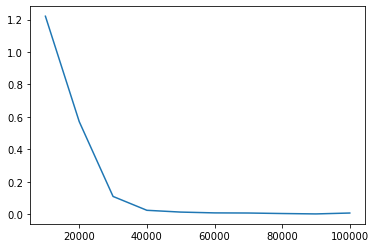

In [6]:
def error_plot():
    nrow=100000
    ncol=100
    
    x=gen_data(nrow,ncol)
    V=init_V(ncol)
    V_true = true_pca(x,ncol)
    error_list=[]
    
    for i in range(10):
        
        V, error = oja(x[i*10000:(i+1)*10000,:], V ,0.001, V_true)
        error_list.append(error)
    
    plt.plot([i*10000 for i in range(1,11)],error_list)
    plt.show()
    
    return V,V_true
    
pca,pca_true = error_plot()
    

## Rotation


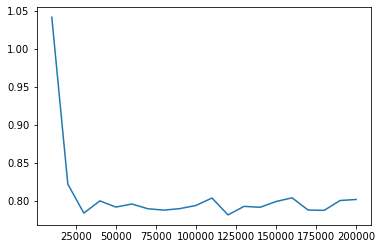

In [7]:
from scipy.stats import special_ortho_group

def error_plot_rotated():
    np.random.seed(999999)
    nrow=200000
    ncol=100
    
    x = gen_data(nrow,ncol)
    r = special_ortho_group.rvs(ncol+2)
    x = r@x.T
    x = x.T
    V = init_V(ncol)
    V_true = np.dot(r,pca_true)
    error_list=[]
    
    for i in range(20):
        
        V, error = oja(x[i*10000:(i+1)*10000,:], V ,0.001, V_true)
        error_list.append(error)
    
    plt.plot([i*10000 for i in range(1,21)],error_list)
    plt.title('difference between Oja\' rule and rotated PCA')
    plt.show()
    
    return V
    
pca_r = error_plot_rotated()

Time taken for PCA 0.9803464412689209
varaince ratio:
[8.20183125e-01 1.79816875e-01 4.96884636e-30 7.57804778e-31
 6.57026058e-31]


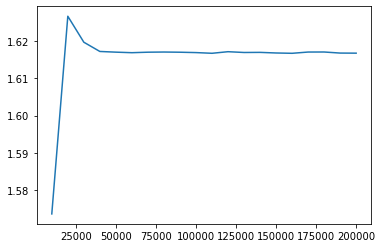

In [8]:
def error_plot_rotated_2():
    np.random.seed(999999)
    nrow=200000
    ncol=100
    
    x = gen_data(nrow,ncol)
    r = special_ortho_group.rvs(ncol+2)
    x = r@x.T
    x = x.T
    V = init_V(ncol)
    V_true = true_pca(x,ncol)
    error_list=[]
    
    for i in range(20):
        
        V, error = oja(x[i*10000:(i+1)*10000,:], V ,0.001, V_true)
        error_list.append(error)
    
    plt.plot([i*10000 for i in range(1,21)],error_list)
    plt.title('difference between Oja\' rule and built-in PCA')
    plt.show()
    
    return V,V_true,r
    
pca_r,pca_true_r,r = error_plot_rotated_2()

This is what quite confused me. In the previous section, I have computed the principle components, $v_1$ and $v_2$, of the pre-rotated dataset which are the same as the one computed by the built-in pca function. In the next setion, after applied a rotation matrix to the dataset, I got 2 new principle components, $v'_1$ and $v'_2$. The following computation shows that $v'_1=R v_1$ and $v'_2=R v_2$, where $R$ is the rotation matrix.However, this not the same as the true PCA computed by the built-in function.

In [9]:
rotated_pca = np.dot(r,pca_true)
difference = np.linalg.norm(np.abs(rotated_pca)-np.abs(pca_r))#PCA from Oja's rule
print(difference)

0.8016401322881468


In [10]:
rotated_pca = np.dot(r,pca_true)
difference = np.linalg.norm(np.abs(rotated_pca)-np.abs(pca_true_r))#PCA from built-in function
print(difference)

1.6151155252713767
